In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
qcd = ObjIter([Tree(fc.eightb.preselection.QCD_B_List)])

In [4]:
varinfo.clear()

In [5]:
(qcd).apply(lambda t:build_collection(t, 'H\dY\d_b\d', 'jet', ptordered=True))

[None]

100%|██████████| 32/32 [00:12<00:00,  2.58it/s]


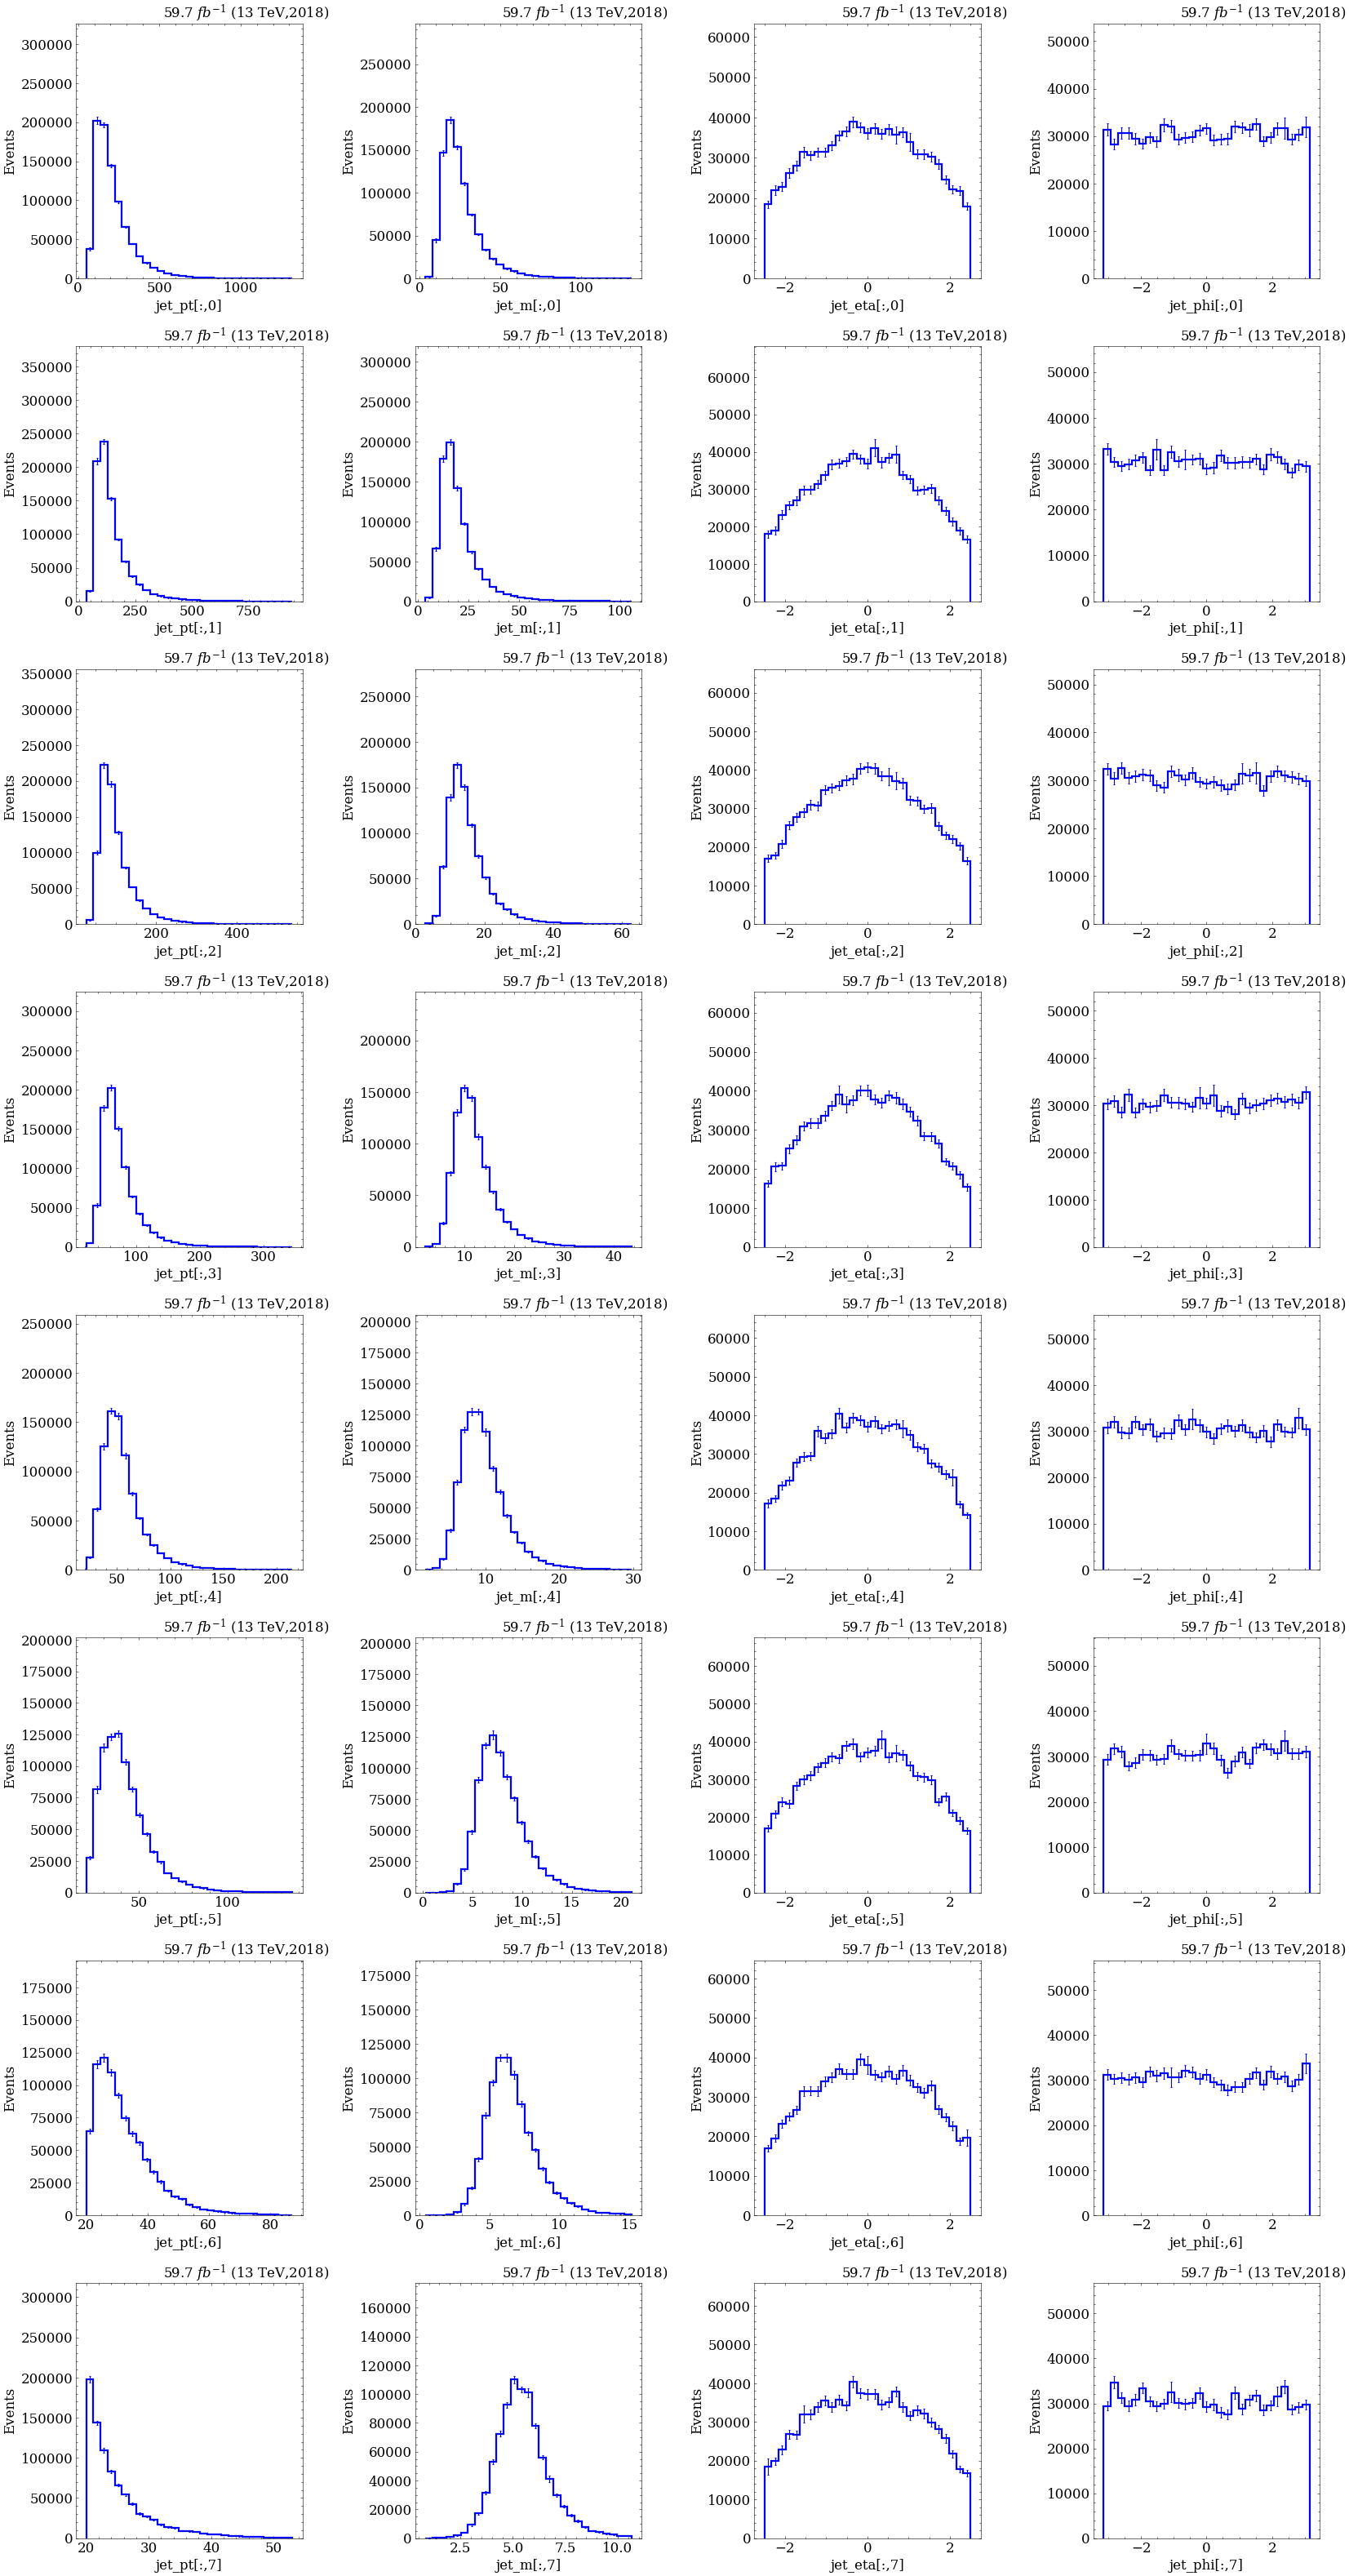

In [6]:
study.quick(
  qcd,
  varlist=[ f'jet_{var}[:,{i}]' for i in range(8) for var in ('pt','m','eta','phi') ],
  dim=(-1,4),
)

In [7]:
quad_index = combinations(8, [4, 4])
def pair_x_y(t):
  jets = get_collection(t, f'jet', False)

  def _y(jets):
    jp4 = [ build_p4(jets[:,i], use_regressed=True) for i in range(4) ]
    yp4 = jp4[0] + jp4[1] + jp4[2] + jp4[3]
    return ak.zip({ var:getattr(yp4,var) for var in ('pt','m','eta','phi') })
  ys = ak_stack([ 
    ak_stack([_y(jets[:,comb[0]]), _y(jets[:,comb[1]])])
    for comb in quad_index 
  ])
  ys = reorder_collection(ys, ak.argsort(-ys.pt, axis=-1))
  y1, y2 = ys[:,:,0], ys[:,:,1]

  yorder = ak.argsort(-(y1.pt+y2.pt),axis=-1)

  t.extend( rename_collection(y1[yorder], f'y1'), rename_collection(y2[yorder], f'y2') )
(qcd).apply(pair_x_y)

[None]

In [8]:
qcd.y1_m

[<Array [[159, 234, ... 2.24e+03, 2.23e+03]] type='111157 * var * float32'>]

100%|██████████| 1/1 [00:27<00:00, 27.97s/it]


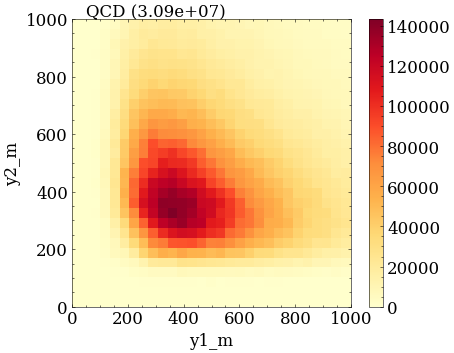

In [9]:
study.quick2d(
  qcd,
  varlist=['y1_m','y2_m'],
  binlist=[(0,1000,30)]*2
  )

In [10]:
ysort

NameError: name 'ysort' is not defined

In [ ]:
pair_index = combinations(4, [2,2])
def pair_y_higgs(t, y='Y1'):
  jets = get_collection(t, f'{y}_jet', False)

  def _higgs(jets):
    jp4 = [ build_p4(jets[:,i], use_regressed=True) for i in range(2) ]
    hp4 = jp4[0] + jp4[1]
    return ak.zip({ var:getattr(hp4,var) for var in ('pt','m','eta','phi') })
  higgs = ak_stack([ 
    ak_stack([_higgs(jets[:,comb[0]]), _higgs(jets[:,comb[1]])])
    for comb in pair_index 
  ])
  higgs = reorder_collection(higgs, ak.argsort(-higgs.pt, axis=-1))
  h1, h2 = higgs[:,:,0], higgs[:,:,1]
  t.extend( rename_collection(h1, f'{y}_h1'), rename_collection(h2, f'{y}_h2') )

(qcd).apply(pair_y_higgs)
(qcd).apply(lambda t:pair_y_higgs(t, y='Y2'))

ValueError: in NumpyArray, too many dimensions in slice

(https://github.com/scikit-hep/awkward-1.0/blob/1.7.0/src/libawkward/array/NumpyArray.cpp#L4680)